<a href="https://colab.research.google.com/github/sharma-chandan/generate_letters_in_different_font/blob/master/bbox_transformation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [471]:
#Mount Google drive (change code for local machine). We need to copy generate_dataset.py script to current directory
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [472]:
!mkdir JPEGImages
!mkdir Annotations
!cp /gdrive/My\ Drive/Colab\ Notebooks/caps_project/faster_rcnn_inception/Images/* JPEGImages/
#Move all xml files to Annotations folder, this is needed for python script used next
!cp /gdrive/My\ Drive/Colab\ Notebooks/caps_project/faster_rcnn_inception/xml/* Annotations/
#Copy generate_dataset.py file to current directory
!cp "/gdrive/My Drive/Colab Notebooks/18-04-2020/ACV - I/Notebooks/Detection/xml_to_csv.py" .


mkdir: cannot create directory ‘JPEGImages’: File exists
mkdir: cannot create directory ‘Annotations’: File exists


In [473]:
!ls -l Annotations | wc -l

516


In [474]:
#Generate csv file from XML file
!python xml_to_csv.py -i Annotations -o vehicle.csv

Successfully converted xml to csv.


In [0]:
from matplotlib import pyplot as plt
import cv2
import numpy as np
import pandas as pd

In [0]:
#Read csv file as pandas dataframe
df = pd.read_csv('vehicle.csv')

In [0]:
#convert all class name to capital letters
df['class'] = df['class'].str.upper()
#delete all classes except A-Z, 0-9, LICENSE_PLATE
df.drop(df[(df['class'].map(len) > 1) & (df['class'] != 'LICENSE_PLATE')].index, inplace = True)
#Calculate Height and width of the bounding box based on co-ordinates
df['bwidth'] = (df['xmax']-df['xmin'])
df['bheight'] = (df['ymax']-df['ymin'])

In [478]:
df

,filename,width,height,class,xmin,ymin,xmax,ymax,bwidth,bheight
0,0a1ef6ea155a020190d37c5e5d7f4673.jpg,768,589,LICENSE_PLATE,86,390,190,451,104,61
1,0a1ef6ea155a020190d37c5e5d7f4673.jpg,768,589,D,94,398,106,420,12,22
2,0a1ef6ea155a020190d37c5e5d7f4673.jpg,768,589,L,105,399,115,422,10,23
3,0a1ef6ea155a020190d37c5e5d7f4673.jpg,768,589,8,114,403,124,424,10,21
4,0a1ef6ea155a020190d37c5e5d7f4673.jpg,768,589,C,124,405,133,427,9,22
...,...,...,...,...,...,...,...,...,...,...
6517,f3bbba187e2243ad5e7110922b1883c3.jpg,1040,780,S,550,419,574,470,24,51
6518,f3bbba187e2243ad5e7110922b1883c3.jpg,1040,780,5,575,414,606,469,31,55
6519,f3bbba187e2243ad5e7110922b1883c3.jpg,1040,780,4,605,418,631,469,26,51
6520,f3bbba187e2243ad5e7110922b1883c3.jpg,1040,780,1,637,418,656,468,19,50


In [479]:
all_classes = df['filename'].unique()
all_classes

array(['0a1ef6ea155a020190d37c5e5d7f4673.jpg',
       '1a6aa41e2db855421d23a9458a3a2e7e.jpg',
       '1d1425af0f302a6034fd5f8e7a2b510b.jpg',
       '2cd5ee47c08c9ff4a24082ed2cdb6804.jpg',
       '01c6aaec842539ebc2377c8a3fe1fe77.jpg',
       '3a8f4970bade0ccb8f6ed570ea64f378.jpg',
       'f95be933ded5ecded6d1d4d675040d49_large.jpg',
       '2e469c681bdad14f491bdda61dd05abb.jpg',
       '0a7a42035a53c057321cf583fc47fba5.jpg',
       'f4b6b93b062db2c3d687af4c98264a95.jpg',
       '1ccd69fa7374faaeca03ca5cf3037fab.jpg',
       '2ff6fecc344befa8e36eae0c1e8a26a1.jpg',
       'ea1914db8e88dab33ddf03b1093eccb7_large.jpg',
       '1a27b445a280b9bf4cc00cb18d188d05.jpg',
       '1a6d2cff13bb72f843580d7152e4f0af_large.jpg',
       'ef75e64a919cb694ad69b15d0028e042.jpg',
       'e0341ff3b3434b8d7cd580d4c1e78612.jpg',
       '02ac5f13a26c56ea7b3a853f7049dd48.jpg',
       '2eb1bb5ff5ffcb5319cfb0b22ec32cf2_large.jpg',
       '01ad3cfe0d6279f8b02d6a5e5ba5642a_extra_large.jpg',
       'e370695fef8c5e29

In [480]:
!mkdir cropped_images
!rm -f cropped_images/*

mkdir: cannot create directory ‘cropped_images’: File exists


In [0]:
def crop_img(image_data):
  image_data.reset_index(drop=True,inplace=True)
  image_name = image_data.loc[0,'filename']
  img = cv2.imread('/content/JPEGImages/' + image_name)
  xmin, ymin, xmax, ymax = image_data.loc[0, ['xmin', 'ymin', 'xmax', 'ymax']]
  cropped_image = img[ymin:ymax, xmin:xmax]
  
  cv2.imwrite('/content/cropped_images/'+image_name,cropped_image)

In [0]:
def process_image(img_data):
  lp_data = pd.DataFrame(img_data[img_data['class'] == 'LICENSE_PLATE'])
  img_data.drop(img_data[img_data['class'] == 'LICENSE_PLATE'].index,inplace = True)
  crop_img(lp_data)
  img_data['n_xmin'] = img_data['xmin'] - lp_data.loc[0,'xmin']
  img_data['n_ymin'] = img_data['ymin'] - lp_data.loc[0,'ymin']
  img_data['n_xmax'] = img_data['n_xmin'] + img_data['bwidth']
  img_data['n_ymax'] = img_data['n_ymin'] + img_data['bheight']
  return img_data
  

In [483]:
new_df = pd.DataFrame(columns=['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax', 'bwidth', 'bheight', 'n_xmin', 'n_ymin', 'n_xmax', 'n_ymax'])
for i in all_classes:
  #print(i)
  df_new = pd.DataFrame(df[df['filename'] == i])
  res = process_image(df_new)
  #print(res)
  new_df = new_df.append(res,ignore_index=True)
  #print(new_df)
  new_df.to_csv('modified_bb.csv', index=False)

KeyError: ignored

In [484]:
!ls -l cropped_images | wc -l

136


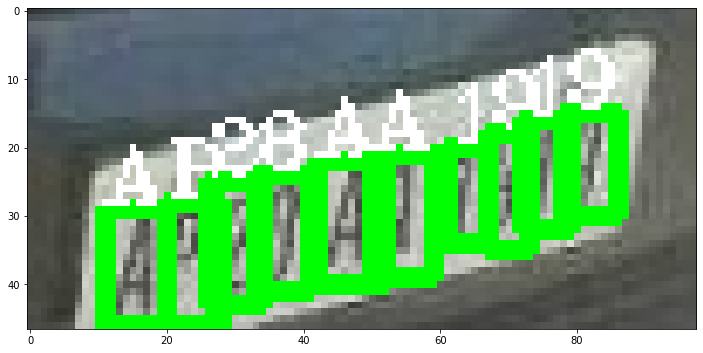

In [470]:
#Pickup a random image number
img_num = np.random.randint(0, new_df.shape[0])

#Read the image
img_file = new_df.loc[img_num,'filename']
#print(img_file)
img = cv2.imread('cropped_images/' + img_file)

#Find all rows which have same file name
rows_with_file = new_df[new_df['filename'] == img_file].index.tolist()

#Draw rectangle(s) as per bounding box information
for i in rows_with_file:

    #Get bounding box
    xmin, ymin, xmax, ymax = new_df.loc[i, ['n_xmin', 'n_ymin', 'n_xmax', 'n_ymax']]
    #Get Label
    label = new_df.loc[i, 'class']
    #Add bounding box
    cv2.rectangle(img, (xmin,ymin), (xmax, ymax), (0,255,0), 2)
    #Add text
    cv2.putText(img,label,(xmin, ymin-1),cv2.FONT_HERSHEY_COMPLEX_SMALL, 0.6, (255, 255, 255), 1)

#Convert BGR format (used by opencv to RGB format used by matplotlib)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

#Draw image using matplotlib
plt.figure(figsize=(12,10))
plt.imshow(img)
plt.show()